In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from utils import data_path

# Load data

In [2]:
simus = ['ssp126',
         'ssp370',
         'ssp585',
         'hist-GHG',
         'hist-aer']

In [3]:
len_historical = 165

In [4]:
X_train = []
Y_train = []

for i, simu in enumerate(simus):

    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'

    # Just load hist data in these cases 'hist-GHG' and 'hist-aer'
    if 'hist' in simu:
        # load inputs 
        input_xr = xr.open_dataset(data_path + input_name)
            
        # load outputs                                                             
        output_xr = xr.open_dataset(data_path + output_name).mean(dim='member')
        output_xr = output_xr.assign({"pr": output_xr.pr * 86400,
                                      "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                                                                               'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    
    # Concatenate with historical data in the case of scenario 'ssp126', 'ssp370' and 'ssp585'
    else:
        # load inputs 
        input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc', 
                                    data_path + input_name]).compute()
            
        # load outputs                                                             
        output_xr = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim='member'),
                               xr.open_dataset(data_path + output_name).mean(dim='member')],
                               dim='time').compute()
        output_xr = output_xr.assign({"pr": output_xr.pr * 86400,
                                      "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                                                                               'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])

    print(input_xr.dims, simu)

    # Append to list 
    X_train.append(input_xr)
    Y_train.append(output_xr)

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


# Data normalization

In [5]:
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def unnormalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return data * std + mean

In [6]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}

for var in ['CO2', 'CH4', 'SO2', 'BC']:
    # To not take the historical data into account several time we have to slice the scenario datasets
    # and only keep the historical data once (in the first ssp index 0 in the simus list)
    array = np.concatenate([X_train[i][var].data for i in [0, 3, 4]] + 
                           [X_train[i][var].sel(time=slice(len_historical, None)).data for i in range(1, 3)])
    print((array.mean(), array.std()))
    meanstd_inputs[var] = (array.mean(), array.std())

(1074.172303244536, 1755.690699230666)
(0.1927369743762821, 0.18457590641432994)
(2.5623359997066755e-12, 2.250114566783271e-11)
(1.4947905009818064e-13, 1.0313342554838387e-12)


In [7]:
# normalize input data 
X_train_norm = [] 
for i, train_xr in enumerate(X_train): 
    for var in ['CO2', 'CH4', 'SO2', 'BC']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))}) 
    X_train_norm.append(train_xr)

## Reshape data to feed into the model 

In [8]:
slider = 10 # years moving temporal window 

In [9]:
# Functions for reshaping the data 
def input_for_training(X_train_xr, skip_historical=False, len_historical=None): 
    
    X_train_np =  X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

    time_length = X_train_np.shape[0]
    # If we skip historical data, the first sequence created has as last element the first scenario data point
    if skip_historical:
        X_train_to_return = np.array([X_train_np[i:i+slider] for i in range(len_historical-slider+1, time_length-slider+1)])
    # Else we just go through the whole dataset historical + scenario (does not matter in the case of 'hist-GHG' and 'hist_aer')
    else:
        X_train_to_return = np.array([X_train_np[i:i+slider] for i in range(0, time_length-slider+1)])
    
    return X_train_to_return 


def output_for_training(Y_train_xr, var, skip_historical=False, len_historical=None): 
    Y_train_np = Y_train_xr[var].data
    
    time_length = Y_train_np.shape[0]
    
    # If we skip historical data, the first sequence created has as target element the first scenario data point
    if skip_historical:
        Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical-slider+1, time_length-slider+1)])
    # Else we just go through the whole dataset historical + scenario (does not matter in the case of 'hist-GHG' and 'hist_aer')
    else:
        Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(0, time_length-slider+1)])
    
    return Y_train_to_return

# CNN - LSTM architecture
## Test on one variable
## Build model

In [10]:
for x in X_train_norm:
    for var_name, data_array in x.data_vars.items():
        print(f"Variable: {var_name}, Shape: {data_array.shape}")


Variable: CO2, Shape: (251,)
Variable: SO2, Shape: (251, 96, 144)
Variable: CH4, Shape: (251,)
Variable: BC, Shape: (251, 96, 144)
Variable: CO2, Shape: (251,)
Variable: SO2, Shape: (251, 96, 144)
Variable: CH4, Shape: (251,)
Variable: BC, Shape: (251, 96, 144)
Variable: CO2, Shape: (251,)
Variable: SO2, Shape: (251, 96, 144)
Variable: CH4, Shape: (251,)
Variable: BC, Shape: (251, 96, 144)
Variable: CO2, Shape: (165,)
Variable: CH4, Shape: (165,)
Variable: BC, Shape: (165, 96, 144)
Variable: SO2, Shape: (165, 96, 144)
Variable: CO2, Shape: (165,)
Variable: CH4, Shape: (165,)
Variable: BC, Shape: (165, 96, 144)
Variable: SO2, Shape: (165, 96, 144)


In [11]:
var_to_predict =  'tas'
# skip_historical set to (i < 2) because of the order of the scenario and historical runs in the X_train and Y_train lists.
# In details: ssp126 0, ssp370 1 = skip historical part of the data, ssp585 2, hist-GHG 3 and hist-aer 4 = keep the whole sequence
X_train_all = np.concatenate([input_for_training(X_train_norm[i], skip_historical=(i<2), len_historical=len_historical) for i in range(len(simus))], axis = 0)
Y_train_all = np.concatenate([output_for_training(Y_train[i], var_to_predict, skip_historical=(i<2), len_historical=len_historical) for i in range(len(simus))], axis=0)
print(X_train_all.shape)
print(Y_train_all.shape)

(726, 10, 96, 144, 4)
(726, 1, 96, 144)


inspo: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

import random 
seed = 6 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2024-01-28 19:25:17.786731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 19:25:17.786768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
keras.backend.clear_session()
cnn_model = None

In [14]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='relu'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))


2024-01-28 19:25:19.150108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 19:25:19.150202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-28 19:25:19.150278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-28 19:25:19.152383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-01-28 19:25:19.152461: W tensorflow/stream_executor/platform/default/dso_loader

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 96, 144, 20)  740       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 48, 72, 20)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 20)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 13824)             359424    
                                                        

In [16]:
cnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse']) 

# Train model

In [17]:
X_train_all.shape, Y_train_all.shape

((726, 10, 96, 144, 4), (726, 1, 96, 144))

In [18]:
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

Epoch 1/30
46/46 [==============================] - 17s 343ms/step - loss: 1.3380 - mse: 1.3380
Epoch 2/30
46/46 [==============================] - 16s 349ms/step - loss: 0.4499 - mse: 0.4499
Epoch 3/30
46/46 [==============================] - 16s 343ms/step - loss: 0.4084 - mse: 0.4084
Epoch 4/30
46/46 [==============================] - 16s 337ms/step - loss: 0.3938 - mse: 0.3938
Epoch 5/30
46/46 [==============================] - 16s 340ms/step - loss: 0.3827 - mse: 0.3827
Epoch 6/30
46/46 [==============================] - 16s 342ms/step - loss: 0.3779 - mse: 0.3779
Epoch 7/30
46/46 [==============================] - 15s 331ms/step - loss: 0.3660 - mse: 0.3660
Epoch 8/30
46/46 [==============================] - 16s 338ms/step - loss: 0.3569 - mse: 0.3569
Epoch 9/30
46/46 [==============================] - 15s 321ms/step - loss: 0.3542 - mse: 0.3542
Epoch 10/30
46/46 [==============================] - 15s 335ms/step - loss: 0.3520 - mse: 0.3520
Epoch 11/30
46/46 [====================

In [19]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model


# Make final prediction for submission

In [20]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = input_for_training(X_test, skip_historical=False, len_historical=len_historical)  

In [21]:
# Make predictions using trained model 
m_pred = cnn_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
m_pred = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015, 2101)).to_dataset(name=var_to_predict)
if ((var_to_predict == "pr90") | (var_to_predict == "pr")):
    m_pred = m_pred.assign({var_to_predict: m_pred[var_to_predict] / 86400})
m_pred

8/8 [==============================] - 1s 153ms/step


<xarray.Dataset>
Dimensions:  (time: 86, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (lat, lon, time) float32 1.082 1.1 1.118 ... 6.497 6.527 6.555

tas


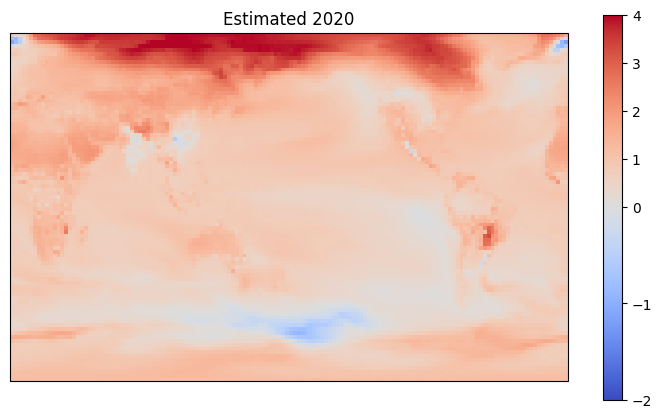

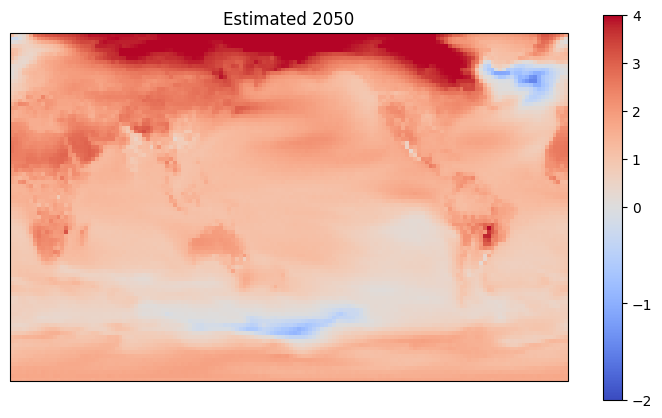

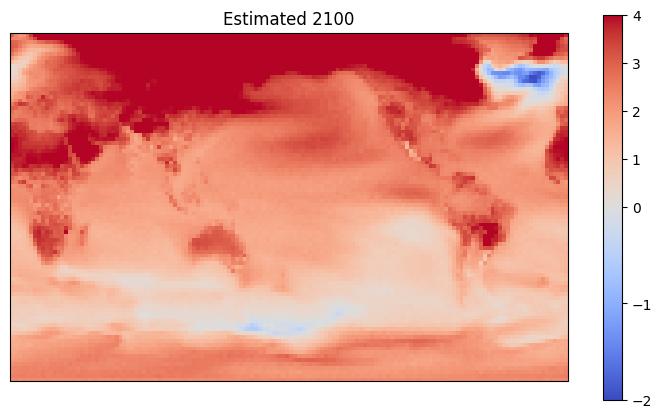

In [22]:
# Plot results 
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=4.)

print(var_to_predict)
for yr in [2020, 2050, 2100]: 
    f, axes = plt.subplots(1, 1,
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(9, 5))

    ctr = axes.pcolormesh(m_pred[var_to_predict].sel(time=yr), cmap="coolwarm", norm=divnorm)
    plt.colorbar(ctr)
    axes.set_title(f"Estimated {yr}")

In [23]:
# Save test predictions as .nc 
# output_name = f'outputs_ssp245_predict_{var_to_predict}.nc'
# m_pred.to_netcdf(data_path + output_name, 'w')

# Run training and predictions for each target variable

In [24]:
vars_to_predict = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize input data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = input_for_training(X_test, skip_historical=False, len_historical=len_historical)  

In [25]:
for var_to_predict in vars_to_predict:
    
    print(var_to_predict)
    
    # Data
    X_train_all = np.concatenate([input_for_training(X_train_norm[i], skip_historical=(i<2), len_historical=len_historical) for i in range(len(simus))], axis = 0)
    Y_train_all = np.concatenate([output_for_training(Y_train[i], var_to_predict, skip_historical=(i<2), len_historical=len_historical) for i in range(len(simus))], axis=0)
    print(X_train_all.shape)
    print(Y_train_all.shape)
    
    # Model    
    keras.backend.clear_session()
    cnn_model = None
    
    cnn_model = Sequential()
    cnn_model.add(Input(shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(AveragePooling2D(2)))
    cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
    cnn_model.add(LSTM(25, activation='relu'))
    cnn_model.add(Dense(1*96*144))
    cnn_model.add(Activation('linear'))
    cnn_model.add(Reshape((1, 96, 144)))
    
    cnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])
    
    hist = cnn_model.fit(X_train_all,
                         Y_train_all,
                         use_multiprocessing=True, 
                         #workers=5, 
                         batch_size=16, epochs=30,
                         verbose=1)
    
    # Make predictions using trained model 
    m_pred = cnn_model.predict(X_test_np)
    # Reshape to xarray 
    m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
    m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
    xr_prediction = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015,2101)).to_dataset(name=var_to_predict)

    if var_to_predict=="pr90" or var_to_predict=="pr":
        xr_prediction = xr_prediction.assign({var_to_predict: xr_prediction[var_to_predict] / 86400})

    # Save test predictions as .nc 
    if var_to_predict == 'diurnal_temperature_range':
        xr_prediction.to_netcdf(data_path + 'outputs_ssp245_predict_dtr.nc', 'w')
    else:
        xr_prediction.to_netcdf(data_path + 'outputs_ssp245_predict_{}.nc'.format(var_to_predict), 'w')
    xr_prediction.close()


tas
(726, 10, 96, 144, 4)
(726, 1, 96, 144)
Epoch 1/30
46/46 [==============================] - 18s 352ms/step - loss: 1.2507 - mse: 1.2507
Epoch 2/30
46/46 [==============================] - 17s 362ms/step - loss: 0.4405 - mse: 0.4405
Epoch 3/30
46/46 [==============================] - 16s 355ms/step - loss: 0.4099 - mse: 0.4099
Epoch 4/30
46/46 [==============================] - 16s 346ms/step - loss: 0.3942 - mse: 0.3942
Epoch 5/30
46/46 [==============================] - 16s 342ms/step - loss: 0.3874 - mse: 0.3874
Epoch 6/30
46/46 [==============================] - 16s 347ms/step - loss: 0.3783 - mse: 0.3783
Epoch 7/30
46/46 [==============================] - 16s 346ms/step - loss: 0.3674 - mse: 0.3674
Epoch 8/30
46/46 [==============================] - 16s 344ms/step - loss: 0.3591 - mse: 0.3591
Epoch 9/30
46/46 [==============================] - 16s 350ms/step - loss: 0.3551 - mse: 0.3551
Epoch 10/30
46/46 [==============================] - 16s 343ms/step - loss: 0.3505 - mse: 0.